## Introduction

In this tutorial we will work with the **gym** environment CartPole.
Gym is OpenAI library that comes with a lot of environments already implemented, such that you have to think of the Reinforcement Learning part of the problem.
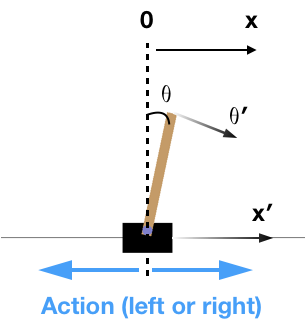

CartPole is one of the most famous ones. The goal is to balance a pole on top of a moving cart, and the only (two) actions available are pushes to the cart in the left or right direction.
An episode is "failed" if the pole is more than 15 degrees from the vertical or if the cart moves more than 2.4 units from the center of the environment.
At each timestep, the RL agent gets a reward=+1 if the pole is still standing. 
The goal is to balance the pole for 200 timesteps (then an episode is considered successful).
The environment is considered **solved** if the RL agent can balance the pole for at least 195 timesteps in 100 consecutive trials (you can challenge other people on the [openAI website](https://gym.openai.com/envs/CartPole-v0/)!) 

Let's now define all the ingredients that we need:
- State: list of 4 values (position and velocity of the cart, angle of the pole (in radians) and pole velocity at the tip)
- Actions: 0 (push cart to the left) or 1 (push cart to the right)
- Reward: +1 for each time step, until the episode is done

It's very easy to use a gym environment.
First, you have to define it:

In [45]:
import gym
env = gym.make('CartPole-v0')
env.reset()

array([ 0.02993718,  0.00134646, -0.02271697,  0.03615845])

You can see that _env.reset()_ returns the initial state of the environment.
Then, you can simply act on it. Each environment has an internal function called _action_space.sample()_ that allows you to sample random actions.
With _render()_ you can also check what is happening.
The function _step()_ outputs the current state of the environment, the reward obtained for the last action, a _done_ boolean variable that indicates if the episode is over, and some other info (that we don't need).
To stop the environment after _done=True_, we need to put a _break_:

In [47]:
t=0
env.reset()
while True:
    env.render()
    next_state, reward, done, _ = env.step(env.action_space.sample())
    t+=1
    if done:
        print("Episode finished after " + str(t) + " timesteps")
        break

Episode finished after 15 timesteps


Since the actions are random, the episode is over after a few timesteps.
Here you can see a full trained RL agent:
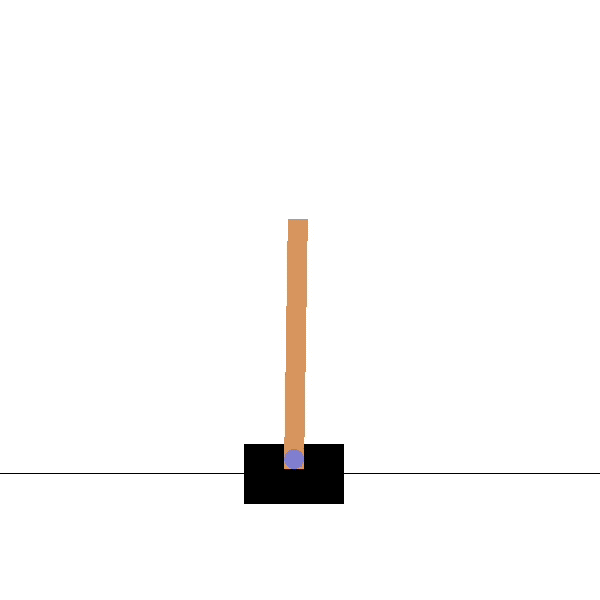

## Import libraries

In [48]:
import gym
import numpy as np
import random
import math
%matplotlib inline
import matplotlib.pyplot as plt


env = gym.make('CartPole-v0')

low = env.observation_space.low
high=env.observation_space.high

input_dim  = env.observation_space.shape[0]
output_dim = env.action_space.n

discount_factor = 0.99 

_low_ and _high_ contain respectively the minimum and maximum values that the state can assume.

## Setup Q_table

<img src="http://wwwuser.gwdg.de/~lsarra/ml4p/04/images/qlearning.png" width="1000px">

Since the state is intrinsically continuous, we need to discretize it to apply Q-learning. 
Empirically, we can ignore the position and velocity of the cart for the training to accelerate the training, since it's uncommon that a trained agent will go out of the bounds in just 200 steps.

First, we define a Q-table with dimension [1,1,6,3], where each number stands for the discrete bins that we choose to discretize each part of the state (1 means that there is only one bin == we ignore it). <br>
Now, you have to implement the Q-learning update rule:
$$Q^{new}(s_t,a_t)=Q^{old}(s_t,a_t)+\alpha (r_t+\gamma \underset{a}{max} Q^{old}(s_{t+1},a) -Q^{old}(s_t,a_t))$$
where $\alpha$ is the learning rate and $\gamma$ the discount factor.

In [49]:
N_discr = [1,1,6,3]  # [position, velocity, angle, angular velocity]

q_table = np.zeros(N_discr + [output_dim,])

def q_learning_update(state, next_state, action, reward):
    learning_rate = get_learning_rate(episode)
    
    best_q = np.amax(q_table[next_state])
    q_table[state + (action,)] += learning_rate*(reward + discount_factor*(best_q) - q_table[state + (action,)])

### Discretize states

We now define a function to discretize a state like this:
<img src="http://wwwuser.gwdg.de/~lsarra/ml4p/04/images/state_discr.png" alt="Drawing" style="width: 600px;"/>
<br>
_discretize_state_ should receive a state as an input and return a tuple, e.g. (0,0,3,2).
We choose the pole angle to be from -15° to 15°, since the episode will be anyway done above this inclination.

In [50]:
low[3], high[3] = -math.radians(15), math.radians(15)

def discretize_state(state):
    discretized_state = []
    for i in range(len(state)):
        if state[i] <= low[i]:
            index = 0
        if state[i] >= high[i]:
            index = N_discr[i] - 1
        else:
            index = int(round((state[i] - low[i])*(N_discr[i]-1)/(high[i]-low[i])))
        discretized_state.append(index)
    discretized_state=np.clip(discretized_state, a_min = 0, a_max = N_discr)
    return tuple(discretized_state)

### Define learning and exploration rates

In [51]:
min_learning_rate = 0.1
beta=0.04

def get_learning_rate(episode):
    return  max(min_learning_rate, min(0.5, 1.0 - math.log10(-beta*(episode+1))))

min_eps=0.01 
max_eps=1 
gamma=0.02

def get_explore_rate(episode):
    return  min_eps + (max_eps - min_eps) * math.exp(-gamma * episode)

Then, we need to define the exploration rate for the agent.
A very important concept in RL is the exploitation-exploration rate ($\epsilon$-greedy).
I want my agent to act with the best action available at each timestep, but to learn what that is, I have to explore every now and then (and a lot more in the beginning!).
Basically, what we will do is to follow this policy:
$$ action=\begin{cases} \mbox{random action} &\mbox{with probability } \epsilon \\ 
\underset{a}{max} Q(s,a) & \mbox{with probability } 1-\epsilon \end{cases}
$$
Usually, a good choice for $\epsilon$ is an exponential decay that stops when it reaches a certain value. Implement this function for $\epsilon$:
$$ \epsilon_{min}+(\epsilon_{max}-\epsilon_{min}) e^{-\beta*episode}$$
with $\epsilon_{min}=0.01$, $\epsilon_{max}=1$ and $\beta=0.02$.
<br><br>
It is helpful even to define a decay for the learning rate. Try to implement this:

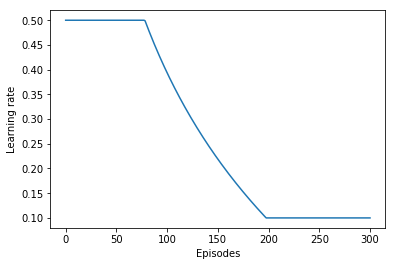

In [56]:
N=300
x=np.linspace(0,N,N)
y=[]
for i in range(N):
    y.append(get_learning_rate(x[i]))
plt.plot(x,y)
plt.xlabel('Episodes')
plt.ylabel('Learning rate')
plt.show()

where the decay goes like $1-log_{10}(-\beta*(episode+1))$ with $\beta=0.04$

## Rule for selection an action

We need a function for choosing an action. Remember the $\epsilon$-greedy approach: choose with probability $\epsilon$ a random action and with probability $1-\epsilon$ the best action available in the Q_table.

In [58]:
def select_action(state, episode):
    explore_rate = get_explore_rate(episode)
    if random.random() < explore_rate:
        return env.action_space.sample()
    else:
        return np.argmax(q_table[state])

## Simulation

Now we can actually simulate the environment and train our agent. We will update the Q-table after each time step (we could also store the data and do it every episode or so).
Remember that the problem is considered solved if the agent can achieve a score of 195 or higher for 100 episodes in a row)

In [59]:
max_episodes = 1000
max_t = 250
combo_goal = 100
timesteps_goal= 195

combo = 0
R=[]

for episode in range(max_episodes):
    state = env.reset()
    state_D = discretize_state(state)
    cumulative_reward=0    
    for t in range(max_t):
        #env.render()
        action = select_action(state_D, episode)     
        next_state, reward, done, _ = env.step(action)
        next_state_D = discretize_state(next_state)     
        if done: 
            if (t >= timesteps_goal):
                combo += 1
            else:
                combo = 0
            next_state = None    
        q_learning_update(state_D, next_state_D, action, reward)
        state_D = next_state_D    
        cumulative_reward+=reward
        if done:
            break
            
    print('Episode: {}'.format(episode), 'Total reward: {}'.format(cumulative_reward))
    R.append(cumulative_reward)
    if combo > combo_goal:
        break

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in float_scalars
  # This is added back by InteractiveShellApp.init_path()


Episode: 0 Total reward: 18.0
Episode: 1 Total reward: 19.0
Episode: 2 Total reward: 44.0
Episode: 3 Total reward: 17.0
Episode: 4 Total reward: 16.0
Episode: 5 Total reward: 15.0
Episode: 6 Total reward: 10.0
Episode: 7 Total reward: 33.0
Episode: 8 Total reward: 16.0
Episode: 9 Total reward: 21.0
Episode: 10 Total reward: 16.0
Episode: 11 Total reward: 16.0
Episode: 12 Total reward: 15.0
Episode: 13 Total reward: 47.0
Episode: 14 Total reward: 10.0
Episode: 15 Total reward: 16.0
Episode: 16 Total reward: 49.0
Episode: 17 Total reward: 10.0
Episode: 18 Total reward: 22.0
Episode: 19 Total reward: 44.0
Episode: 20 Total reward: 13.0
Episode: 21 Total reward: 80.0
Episode: 22 Total reward: 27.0
Episode: 23 Total reward: 14.0
Episode: 24 Total reward: 73.0
Episode: 25 Total reward: 10.0
Episode: 26 Total reward: 32.0
Episode: 27 Total reward: 9.0
Episode: 28 Total reward: 40.0
Episode: 29 Total reward: 27.0
Episode: 30 Total reward: 9.0
Episode: 31 Total reward: 52.0
Episode: 32 Total re

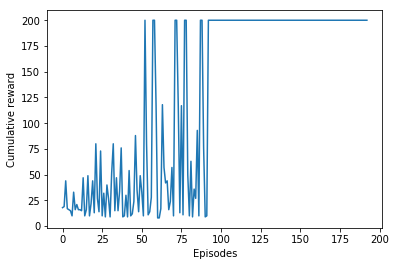

In [60]:
plt.plot(R)
plt.xlabel("Episodes")
plt.ylabel("Cumulative reward")
plt.show()